In [ ]:
# from google.colab import files
#
# uploaded = files.upload()
#
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
#
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
# !cd /content/
# !kaggle datasets download -d siddharthkumarsah/ships-in-aerial-images
# !unzip ships-in-aerial-images.zip

# **Imports**

In [3]:
!pip install super-gradients==3.1.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 964.2/964.2 kB 15.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 697.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 11.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 57.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 76.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade pillow
!pip install --upgrade torchvision

In [4]:
import os
import random
import torch
import requests

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

[2023-06-16 23:27:27] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-06-16 23:27:41] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-16 23:27:41] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-16 23:27:41] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-16 23:27:41] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-06-16 23:27:41] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-06-16 23:27:41] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx required but not found
[2023-06-16 23:27:41] WARNING - env_sanity_check.py - Failed to verify installed packages: hydra-core required but not found
[2023-06-16 23:27:41] WARNING - env_sanity_check.py - Failed to verify installed packages: omegaconf required but not found
[2023-06-16 23:27:41] WARNING - env_sanity_check.py - Failed to verify installed packages: onnxruntime required but not found
[2023-06-16 23:27:41] WAR

Super gradients YOLO import


# Config

In [7]:
class config:
    CHECKPOINT_DIR = 'checkpoints'
    EXPERIMENT_NAME = 'vesselFinder'
    DATA_DIR = '/kaggle/input/ships-in-aerial-images/ships-aerial-images'
    TRAIN_IMAGES_DIR = 'train/images'
    TRAIN_LABELS_DIR = 'train/labels'

    VAL_IMAGES_DIR = 'valid/images'
    VAL_LABELS_DIR = 'valid/labels'

    TEST_IMAGES_DIR = 'test/images'
    TEST_LABELS_DIR = 'test/labels'

    CLASSES = ['ship']
    NUM_CLASSES = len(CLASSES)

    DATALOADER_PARAMS={
    'batch_size':8,
    'num_workers':2
    }

    MODEL_NAME = 'yolo_nas_l'
    PRETRAINED_WEIGHTS = 'coco'



## Trainer Setup

In [ ]:
trainer = Trainer(experiment_name = config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

In [9]:
train_data= coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)
test_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Caching annotations:   1%|          | 111/9697 [00:00<00:29, 327.32it/s]


KeyboardInterrupt: 

In [ ]:
train_data.dataset.plot()

# Model

In [10]:
model = models.get(config.MODEL_NAME,num_classes=config.NUM_CLASSES,pretrained_weights=config.PRETRAINED_WEIGHTS)

[2023-06-16 23:28:39] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:10<00:00, 26.2MB/s] 


# Training parameters

In [ ]:
train_params = {
    # ENABLING SILENT MODE
    #"resume":True,
    "device": "cuda",  # Use CUDA for GPU acceleration
    "parallel": True,  # Enable parallel training on multiple GPUs
    "num_gpus": 2,     # Number of GPUs to use
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
        "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# Training

In [ ]:
trainer.train(model=model,training_params=train_params,train_loader=train_data,valid_loader=val_data)

In [11]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

[2023-06-16 23:29:01] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/vesselFinder/average_model.pth EMA checkpoint.


In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
               top_k_predictions=300,
               num_cls=config.NUM_CLASSES,
               normalize_targets=True,
               post_prediction_callback=PPYoloEPostPredictionCallback(
                  score_threshold=0.01,
                  nms_top_k=1000,
                  max_predictions=300,
                  nms_threshold=0.7)
               ))

In [ ]:
tpaths=[]
for dirname, _, filenames in os.walk('/kaggle/input/ships-in-aerial-images/ships-aerial-images/test/images'):
    for filename in filenames:
        tpaths+=[(os.path.join(dirname, filename))]
tpaths2=random.sample(tpaths,10)

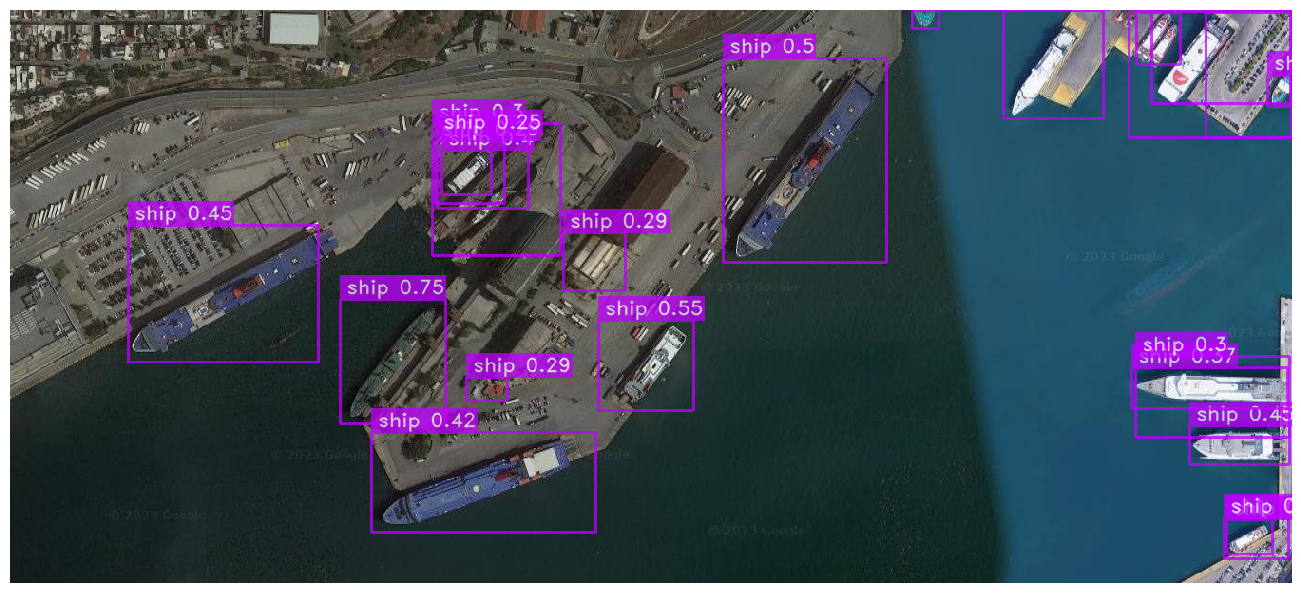

In [12]:
best_model.predict('/kaggle/input/random/2023-06-16 13_39_19-Google Maps.png', conf=0.25).show()
